###  Created by Luis A. Sanchez-Perez (alejand@umich.edu).
<p><span style="color:green"><b>Copyright &#169;</b> Do not distribute or use without authorization from author.</span></p>

<p><span style="color:red"><b>NOTE: </b> Do not modify any of the cells (with code) provided in this notebook or you might have problems finishing the assignment.</span></p>

## Part I - General overview
Your main goal will be to implement a graph computation as the one shown in the picture below. At a high level view you might split this assignment in the following tasks:
1. Implement each of the nodes in the graph, including its foward pass and backward pass (backpropagation of the gradient).
2. Design the graph by creating the proper nodes.
3. Find the optimal parameters in the graph to minimize its output. You will implement the training loop using gradient descent and any of the available optimizers.

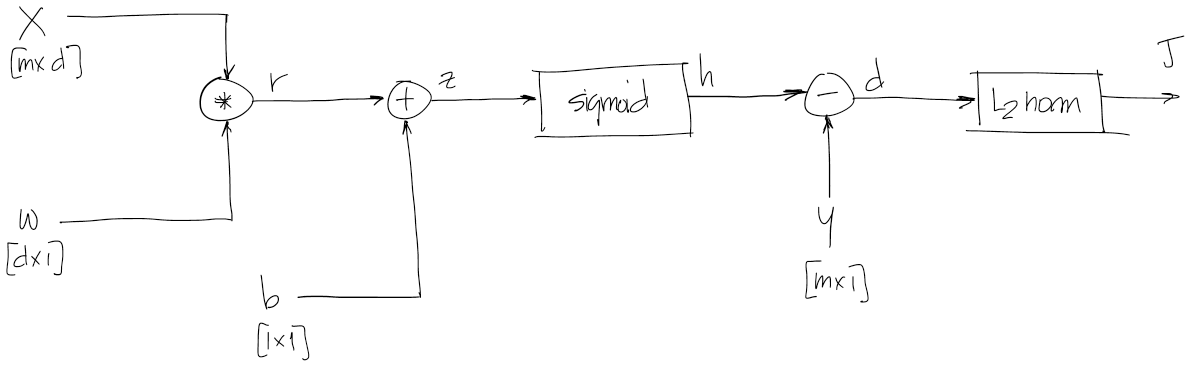</img>

## Part II - Setting up libraries & utility functions
Do not modify anything on this section

In [1]:
# Do not modify or delete this!
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Do not modify or delete this!
def plot_boundary(h_node,X_node,
                  X_train,y_train,X_test,y_test,
                  poly=None,scaler=None,xlim=(0,1),ylim=(0,1)):
    # Creates an auxiliary graph
    g = Graph()
    # Generates mesh
    pts = 100
    x1 = np.linspace(xlim[0], xlim[1], pts)  # x1
    x2 = np.linspace(ylim[0], ylim[1], pts)  # x2
    x1, x2 = np.meshgrid(x1, x2)
    mesh = np.vstack((x1.flatten(), x2.flatten())).T
    if poly is not None:
        mesh = poly.transform(mesh)
    if scaler is not None:
        mesh = scaler.transform(mesh)    
    # Training set
    if scaler is not None:
        temp = scaler.inverse_transform(X_train)
    plt.scatter(temp[:,0],temp[:,1],cmap='viridis',c=y_train.flatten(),s=50,edgecolor='k')
    # Boundary
    threshold = 0.5
    g.build(h_node)
    g.feed({X_node: mesh})
    g.forward()
    h = h_node.value
    plt.contour(x1, x2, h.reshape((pts,pts)), levels = [threshold], colors='black')
    # Decision regions
    y_pred = (h >= threshold).reshape((pts,pts))
    plt.contourf(x1, x2, y_pred, alpha = 0.10,cmap='viridis')
    # Test set
    g.feed({X_node: X_test})
    g.forward()
    h = h_node.value
    y_pred = (h >= threshold)
    correct = (y_pred == y_test).flatten()
    if scaler is not None:
        temp = scaler.inverse_transform(X_test)
    plt.scatter(temp[correct,0],temp[correct,1], marker='.', c='black', s=60)
    plt.scatter(temp[~correct,0],temp[~correct,1], marker='x', c='black', s=60)

## Part III - Implementing each node
In this part you will be implementing each node necessary to design the graph shown above.

In [3]:
# Do not modify or delete this! You might need these imports
from graphs.core import Param
from graphs.core import DataHolder
from graphs.core import Graph
from graphs.core import Operation

### Question Q1.
Implement the node computing the linear combination $r=Xw$. As a start-up, the solution for this question is given below.

In [4]:
# Do not modify or delete this!
class linear_node(Operation):
    """
    Computes the linear combination of all m observations in X [m x d] as
    specified in w [d x n]
    """
    def __init__(self, X, w):
        super().__init__(X, w)

    def forward(self):
        super().forward()
        X = self.inputs[0].value
        w = self.inputs[1].value
        self.value = X.dot(w)

    def backward(self):
        X = self.inputs[0].value
        w = self.inputs[1].value
        m, n = self.value.shape
        downstream = self.gradient.reshape((m, n))
        # Gradient with respect to X
        if self.inputs[0].needs_backprop():
            upstream = downstream.dot(w.T).reshape(-1, 1)
            self.inputs[0].upgradient(upstream)
        # Gradient with respect to w
        if self.inputs[1].needs_backprop():
            upstream = X.T.dot(downstream).reshape(-1, 1)
            self.inputs[1].upgradient(upstream)

#### Unit test (Q1)
If your implementation is correct, the function call in the cell below will produce the following output:
<br>
<br>
<span style="color:#000; font-family: 'Consolas'; font-size: 1em;">
Forward pass: Correct<br>
Backward pass: Correct
</span>

In [5]:
# Do not modify this cell!
def unit_test():
    # Builds testing graph
    g = Graph()
    X = np.array([[0.5, 0.3],[-0.2,0.1]])
    w = np.array([[3.],[4.]])
    grad = np.array([[2.],[3.]])
    node_1 = Param(shape=(2,2))    
    node_2 = Param(shape=(2,1))
    node_3 = linear_node(node_1,node_2)
    node_1.value = X
    node_2.value = w
    node_3.gradient = grad
    g.build(node_3)
    g.forward().backward()
    # Checks forward pass
    check = (np.abs(node_3.value - np.array([[2.7],[-0.2]])) < 1e-5).all()
    print('Forward pass:','Correct' if check else 'Incorrect')
    # Checks backward pass
    check = (np.abs(node_1.gradient - np.array([6.,8.,9.,12.], ndmin=2).T) < 1e-5).all()
    check &= (np.abs(node_2.gradient - np.array([[0.4],[0.9]])) < 1e-5).all()
    print('Backward pass:','Correct' if check else 'Incorrect')
    
unit_test()

Forward pass: Correct
Backward pass: Correct


### Question Q2.
Implement the node adding the bias term, that is, the node which output is $z$.

**Important:** Name your class `bias_node`.

In [6]:
class bias_node(Operation):

    def __init__(self, r, b):
        super().__init__(r, b)

    def forward(self):
        super().forward()
        r = self.inputs[0].value
        b = self.inputs[1].value
        self.value = r + b

    def backward(self):
        r = self.inputs[0].value
        b = self.inputs[1].value
        m, n = self.value.shape
        downstream = self.gradient.reshape((m, n))
        # Gradient with respect to r
        if self.inputs[0].needs_backprop():
            localgrad = np.identity(m)
            upstream = localgrad.T.dot(downstream).reshape(-1, 1)
            self.inputs[0].upgradient(upstream)
        # Gradient with respect to b
        if self.inputs[1].needs_backprop():
            localgrad = np.array([[1] * n] * m)
            upstream = localgrad.T.dot(downstream).reshape(-1, 1)
            self.inputs[1].upgradient(upstream)

#### Unit test (Q2)
If your implementation is correct, the function call in the cell below will produce the following output:
<br>
<br>
<span style="color:#000; font-family: 'Consolas'; font-size: 1em;">
Forward pass: Correct<br>
Backward pass: Correct
</span>

In [7]:
# Do not modify this cell!
def unit_test():
    # Builds testing graph
    g = Graph()
    X = np.array([[0.5, 0.3],[-0.2,0.1]])
    w = np.array([[3.],[4.]])
    r = X.dot(w)
    b = np.array([1])
    grad = np.array([[2.],[3.]])
    node_1 = Param(shape=r.shape)    
    node_2 = Param(shape=b.shape)
    node_3 = bias_node(node_1,node_2)
    node_1.value = r
    node_2.value = b
    node_3.gradient = grad
    g.build(node_3)
    g.forward().backward()
    # Checks foward pass
    check = (np.abs(node_3.value - np.array([[3.7],[0.8]])) < 1e-5).all()
    print('Forward pass:','Correct' if check else 'Incorrect')
    # Checks backward pass
    check = (np.abs(node_1.gradient - np.array([[2.],[3.]])) < 1e-5).all()
    check &= (np.abs(node_2.gradient - np.array([[2.],[3.]]).sum()) < 1e-5).all()
    print('Backward pass:','Correct' if check else 'Incorrect')
    
unit_test()

Forward pass: Correct
Backward pass: Correct


### Question Q3.
Implement the sigmoid node, that is, the node which output is $h$.

**Important:** Name your class `sigmoid_node`.

In [8]:
class sigmoid_node(Operation):

    def __init__(self, z):
        super().__init__(z)

    def forward(self):
        super().forward()
        z = self.inputs[0].value
        self.value = 1/(1+np.exp(-z))

    def backward(self):
        r = self.inputs[0].value
        m, n = self.value.shape
        downstream = self.gradient.reshape((m, n))
        # Gradient with respect to z
        if self.inputs[0].needs_backprop():
            localgrad = np.identity(m)
            np.fill_diagonal(localgrad,self.value*(1-self.value))
            upstream = localgrad.T.dot(downstream).reshape(-1, 1)
            self.inputs[0].upgradient(upstream)

#### Unit test (Q3)
If your implementation is correct, the function call in the cell below will produce the following output:
<br>
<br>
<span style="color:#000; font-family: 'Consolas'; font-size: 1em;">
Forward pass: Correct<br>
Backward pass: Correct
</span>

In [9]:
# Do not modify this cell!
def unit_test():
    # Builds testing graph
    g = Graph()
    z = np.array([[0.2],[2.1]])
    grad = np.array([[2.],[3.]])
    node_1 = Param(shape=z.shape)
    node_2 = sigmoid_node(node_1)
    node_1.value = z
    node_2.gradient = grad
    g.build(node_2)
    g.forward().backward()
    # Checks foward pass
    check = (np.abs(node_2.value - np.array([[0.549834],[0.89090318]])) < 1e-5).all()
    print('Forward pass:','Correct' if check else 'Incorrect')
    # Checks backward pass    
    check = (np.abs(node_1.gradient - np.array([[0.49503315],[0.29158411]])) < 1e-5).all()
    print('Backward pass:','Correct' if check else 'Incorrect')
    
unit_test()

Forward pass: Correct
Backward pass: Correct


### Question Q4.
Implement the substraction node, that is, the node which output is $d$.

**Important:** Name your class `diff_node`.

In [10]:
class diff_node(Operation):

    def __init__(self, h, y):
        super().__init__(h, y)

    def forward(self):
        super().forward()
        h = self.inputs[0].value
        y = self.inputs[1].value
        self.value = h - y

    def backward(self):
        h = self.inputs[0].value
        y = self.inputs[1].value
        m, n = self.value.shape
        downstream = self.gradient.reshape((m, n))
        # Gradient with respect to h
        if self.inputs[0].needs_backprop():
            localgrad = np.identity(m)
            upstream = localgrad.T.dot(downstream).reshape(-1, 1)
            self.inputs[0].upgradient(upstream)
        # Gradient with respect to y
        if self.inputs[1].needs_backprop():
            localgrad = np.identity(m) * -1
            upstream = localgrad.T.dot(downstream).reshape(-1, 1)
            self.inputs[1].upgradient(upstream)

#### Unit test (Q4)
If your implementation is correct, the function call in the cell below will produce the following output:
<br>
<br>
<span style="color:#000; font-family: 'Consolas'; font-size: 1em;">
Forward pass: Correct<br>
Backward pass: Correct
</span>

In [11]:
# Do not modify this cell!
def unit_test():
    # Builds testing graph
    g = Graph()
    h = np.array([[0.5],[0.8]])
    y = np.array([[1.],[0.]])
    grad = np.array([[2.],[3.]])
    node_1 = Param(shape=h.shape)    
    node_2 = Param(shape=y.shape)
    node_3 = diff_node(node_1,node_2)
    node_1.value = h
    node_2.value = y
    node_3.gradient = grad
    g.build(node_3)
    g.forward().backward()
    # Checks foward pass
    check = (np.abs(node_3.value - np.array([[-0.5],[0.8]])) < 1e-5).all()
    print('Forward pass:','Correct' if check else 'Incorrect')
    # Checks backward pass
    check = (np.abs(node_1.gradient - np.array([[2.],[3.]])) < 1e-5).all()
    check &= (np.abs(node_2.gradient + np.array([[2.],[3.]])) < 1e-5).all()
    print('Backward pass:','Correct' if check else 'Incorrect')
    
unit_test()

Forward pass: Correct
Backward pass: Correct


### Question Q5.
Implement the L2 node, that is, the node which output is $J$.

**Important:** Name your class `l2_node`.

In [12]:
class l2_node(Operation):

    def __init__(self, d):
        super().__init__(d)

    def forward(self):
        super().forward()
        d = self.inputs[0].value
        self.value = sum(d*d)

    def backward(self):
        d = self.inputs[0].value
        n, = self.value.shape
        downstream = self.gradient.reshape((n,))
        # Gradient with respect to z
        if self.inputs[0].needs_backprop():
            localgrad = (2*d).T
            upstream = localgrad.T.dot(downstream).reshape(-1, 1)
            self.inputs[0].upgradient(upstream)

#### Unit test (Q5)
If your implementation is correct, the function call in the cell below will produce the following output:
<br>
<br>
<span style="color:#000; font-family: 'Consolas'; font-size: 1em;">
Forward pass: Correct<br>
Backward pass: Correct
</span>

In [13]:
# Do not modify this cell!
def unit_test():
    g = Graph()
    d = np.array([[0.5],[0.8]])
    node_1 = Param(shape=d.shape) 
    node_2 = l2_node(node_1)
    node_1.value = d
    g.build(node_2)
    g.forward().backward()
    # Checks foward pass
    check = (np.abs(node_2.value - 0.89) < 1e-5).all()
    print('Forward pass:','Correct' if check else 'Incorrect')
    # Checks backward pass
    check = (np.abs(node_1.gradient - np.array([[1.],[1.6]])) < 1e-5).all()
    print('Backward pass:','Correct' if check else 'Incorrect')
    
unit_test()

Forward pass: Correct
Backward pass: Correct


## Part IV - Creating a graph
In this part you will be creating a graph that performs the operations shown in the diagram above in the correct order. For this you have to use the implementations you created before. Your graph will be tested in the randomly generated dataset shown below.

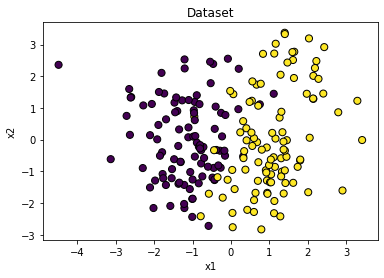

In [14]:
# Generating dataset. Do not modify this cell!
obs = 200
X, y = make_classification(n_samples=obs, n_features=2, n_redundant=0, n_informative=2)
y = y.reshape((-1,1))
plt.title('Dataset')
plt.scatter(X[:,0], X[:,1], marker='o', c=y.flatten(), s=50, edgecolor='k',cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
# Splits into training/test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)
# Expand dataset to include polynomial features
d = 7
ps = PolynomialFeatures(degree = d,include_bias=False)
ps.fit(X_train)
X_train = ps.transform(X_train)
X_test = ps.transform(X_test)
# Standarize dataset
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Question Q6.
Using the nodes you implemented before, construct a graph as shown in the diagram above.

**Important:** Name the last operation of your graph `J_node`.

The `graph` object will be used to perform the forward and backward pass, providing the input data for all dataholders involved.

In [15]:
# Creates graph object. Do not modify this cell!
graph = Graph()

Below we create all `DataHolder` and `Param` nodes necessary to construct the graph.

In [16]:
# Creates dataholders and params for the graph. Do not modify or delete this!
m,d = X_train.shape
X_node = DataHolder()
y_node = DataHolder()
w_node = Param(shape=(d,1))
b_node = Param(shape=(1,1))

In the cell below you are required to construct the connections in the graph by using your operations implementations. Remember to named your last node in the graph as `J_node`.

In [17]:
r_node = linear_node(X_node, w_node)
z_node = bias_node(r_node, b_node)
h_node = sigmoid_node(z_node)
d_node = diff_node(h_node, y_node)
J_node = l2_node(d_node)

Compiles and tests the graph

In [18]:
# Compiles and initialize the graph params. Do not modify this cell!
graph.build(J_node).initialize()

In [19]:
# Feeds data for training
graph.feed({X_node: X_train, y_node: y_train})

In [20]:
# Outputs the forward pass result, i.e. the cost J. Do not modify this cell!
graph.forward()
J_node.value

array([50.9775983])

#### Unit test (Q6)
If the graph is built correctly, the function call in the cell below should produce `True` as output.

In [21]:
def unit_test(g,w,b,X,y):
    g.forward()
    z = X.dot(w) + b
    h = 1/(1 + np.exp(-z))
    diff = (h - y)
    return np.abs(diff.T.dot(diff).flatten() - g.operation.value.flatten()) < 1e-5

unit_test(graph,graph.params[0].value,graph.params[1].value,X_train,y_train)

array([ True])

## Part V - Implementing training
In this part you will be finding the optimal parameters in the graph to minimize its output. You will use gradient descend and any of the optimizers available.

### Question Q7.
As you probably noticed already the graph we built represents a logistic regression classifier with SSE cost function. Your task in this question is to compute the accuracy (for the training & test sets) of the default graph you built, that is, the graph using the random weights and bias we generated before. The output of your cell should have the following format:
<br>
<span style="color:#000; font-family: 'Consolas'; font-size: 1em;">  
Accuracy (Training):  #.##<br>
Accuracy (Test):  #.##
</span>


**Important:** You must use the graph in some way to compute this. Also, unless you are really really lucky you should expect a poor performance on both sets.

In [22]:
# Compute Accuracy for Training Set
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
expected_values_train = y_train
predicted_values_train = h_node.value >= 0.5
acc_train = sum((expected_values_train == predicted_values_train).astype('int'))/len(y_train)
# from sklearn.metrics import accuracy_score
# acc_check_train = accuracy_score(expected_values_train, predicted_values_train)
print('Accuracy (Training):  ', acc_train)

# Compute Accuracy for Training Set
graph.feed({X_node: X_test, y_node: y_test})
graph.forward()
expected_values_test = y_test
predicted_values_test = h_node.value >= 0.5
acc_test = sum((expected_values_test == predicted_values_test).astype('int'))/len(y_test)
# acc_check_test = accuracy_score(expected_values_test, predicted_values_test)
print('Accuracy (Test):  ', acc_test)

Accuracy (Training):   [0.24]
Accuracy (Test):   [0.14]


#### Unit test (Q7)
Your accuracy computations should appear reasonable when compare to the ouput of the cell below.

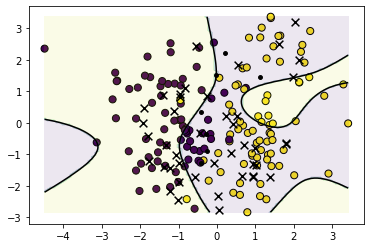

In [23]:
# Plots boundary
plot_boundary(J_node.inputs[0].inputs[0], X_node,
              X_train,y_train,X_test,y_test,
              poly=ps,scaler=sc,
              xlim=(X[:,0].min(), X[:,0].max()),
              ylim=(X[:,1].min(), X[:,1].max()))

### Question Q8.
Here you should implement a training loop that uses any of the ptimizers imported in the cell below to update the parameters of the graph so as to minimize its output. You must stop the training if any of the following conditions are true:
* A maximum of `1000` iterations has been reached.
* The cost function did not change more than `1e-5`.

In [24]:
# Optimizers available. Do not modify this cell!
from graphs.optimizers import AdamOptimizer
from graphs.optimizers import AdagradOptimizer
from graphs.optimizers import RMSPropOptimizer
from graphs.optimizers import RPropOptimizer

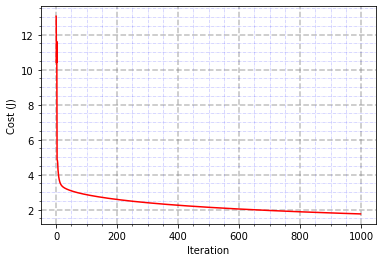

In [25]:
# Training Loop
cost_before_update = np.array([[None] * 1000] * 1)
cost_after_update = np.array([[None] * 1000] * 1)
cost_change = np.array([[None] * 1000] * 1)
optimizer = AdagradOptimizer()
optimizer.reset([w_node, b_node])
for i in list(range(1000)):

    # Forward pass through graph - before update
    graph.forward()
    cost_before_update[0, i] = J_node.value

    # use optimizer to update weights
    graph.backward()
    optimizer.update([w_node, b_node], [w_node.gradient, b_node.gradient])

    #  Forward pass through graph - after update
    graph.forward()
    cost_after_update[0, i] = J_node.value

    #  Check change in cost  
    cost_change[0, i] = abs(cost_before_update[0, i] - cost_after_update[0, i])
    if cost_change[0, i] <= 1e-5:
        break

fig, ax = plt.subplots()
ax.plot(range(i), cost_after_update[0, range(i)], color='red')
ax.set(xlabel='Iteration', ylabel='Cost (J)')
plt.grid(color='grey', which='major', alpha=0.5, linestyle='--', linewidth=1.5)
plt.minorticks_on()
plt.grid(color='blue', which='minor', alpha=0.3, linestyle='-.', linewidth=0.5)
plt.show()

#### Unit test (Q8)
Compute the accuracy again (for the training & test sets) of the graph you built, after the parameters have been updated during training. The output of your cell should have the following format:
<br>
<span style="color:#000; font-family: 'Consolas'; font-size: 1em;">  
Accuracy (Training):  #.##<br>
Accuracy (Test):  #.##
</span>

**Important:** If your training implementation is correct, must of the time you should get an accuracy above 0.90 in both sets.

In [26]:
# Compute Accuracy for Training Set
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
expected_values_train = y_train
predicted_values_train = h_node.value >= 0.5
acc_train = sum((expected_values_train == predicted_values_train).astype('int'))/len(y_train)
# acc_check_train = accuracy_score(expected_values_train, predicted_values_train)
print('Accuracy (Training):  ', acc_train)

# Compute Accuracy for Training Set
graph.feed({X_node: X_test, y_node: y_test})
graph.forward()
expected_values_test = y_test
predicted_values_test = h_node.value >= 0.5
acc_test = sum((expected_values_test == predicted_values_test).astype('int'))/len(y_test)
# acc_check_test = accuracy_score(expected_values_test, predicted_values_test)
print('Accuracy (Test):  ', acc_test)

Accuracy (Training):   [0.93333333]
Accuracy (Test):   [0.98]


#### Unit test (Q8)
If your training implementation is correct, the cell below will produce a boundary plot in accordance with your performance metrics.

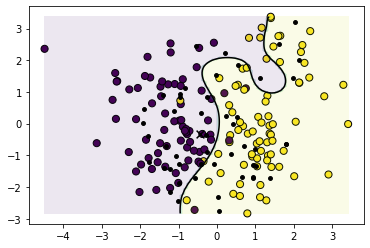

In [27]:
# Plots boundary
plot_boundary(J_node.inputs[0].inputs[0], X_node,
              X_train,y_train,X_test,y_test,
              poly=ps,scaler=sc,
              xlim=(X[:,0].min(), X[:,0].max()),
              ylim=(X[:,1].min(), X[:,1].max()))